In [1]:
import numpy as np
from scipy import signal
import matplotlib.pyplot as plt

In [2]:
def get_frac_delay_length():
    return 81

def get_reflection_time(max_order):
    max_order_sq = max_order * max_order
    return int((1 + 2 * max_order * (2 * max_order_sq + 3 * max_order + 4) / 3))

def fractional_delay(t0):
    N = get_frac_delay_length()
    return np.hanning(N) * np.sinc(np.arange(N) - (N - 1) / 2 - t0)

def build_rir(time, alpha, visibility, fs, fdl):

    # fractional delay length
    fdl = get_frac_delay_length()
    fdl2 = (fdl - 1) // 2

    # the number of samples needed
    N = int(np.ceil(time.max() * fs) + fdl)

    ir_ref = np.zeros(N)

    # pure Python implemenation
    for i in range(time.shape[0]):
        if visibility[i] == 1:
            time_ip = int(np.round(fs * time[i]))
            time_fp = (fs * time[i]) - time_ip
            ir_ref[time_ip - fdl2 : time_ip + fdl2 + 1] += alpha[i] * fractional_delay(time_fp)

    return ir_ref

In [3]:
ism_order = 10
room = np.array([3.2, 4, 2.7])
src  = np.array([2, 3, 2])
mic  = np.array([1.1, 1, 1.2])
fs   = 48000
c    = 343
fdl  = get_frac_delay_length()
fdl2 = fdl // 2

In [4]:
n_reflections = get_reflection_time(ism_order)
image_sources_order = np.zeros((n_reflections, 3))
image_sources = np.zeros((n_reflections, 3))

z_max = ism_order
index = 0

for z in range(-z_max, z_max+1):
    y_max = ism_order - abs(z)
    for y in range(-y_max, y_max+1):
        x_max = y_max - abs(y)
        if (x_max < 0): x_max = 0
        for x in range(-x_max, x_max+1):
            image_sources_order[index] = [x, y, z]
            steps = np.empty(3)
            
            for d in range(3):
                if(abs(image_sources_order[index][d]) % 2 == 1):
                    step = room[d] - src[d]
                else:
                    step = src[d]
                image_sources[index][d] = image_sources_order[index][d] * room[d] + step
            
            index = index + 1

dist = np.sqrt(np.sum((image_sources.T - mic[:, None]) ** 2, axis=0))
time = dist / c
t_max = time.max()
N = int(np.ceil(t_max * fs))

alpha = np.ones(n_reflections) / dist
vis = np.ones(n_reflections).astype(np.int32)
time_adjust = time + fdl2 / fs
ir_loc = build_rir(time_adjust, alpha, vis, fs, fdl)

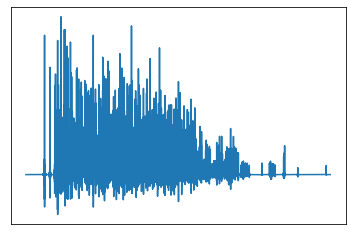

In [5]:
# plt.title('amplitude taps of RIR')
# plt.xlabel(r'time (n sample)')
plt.xticks([])
plt.yticks([])
# ax.axes.xaxis.set_visible(False)
# ax.axes.yaxis.set_visible(False)
plt.plot(ir_loc)
plt.show()